# CIn - UFPE
# Aprendizagem por Reforço 2020.1
## Docente: Hansenclever F. Bassini
## Discentes: Bruno Mota, Jairo Raphael, Rodrigo Lima

### Conteúdo: Reinforcement Learning for Test Case Priorization in Continuous Integration  



## Importando arquivos

In [1]:
from google.colab import files
uploaded = files.upload()
import io

Saving rq_lstmclassifier_iofrol_failcount_0_stats.p to rq_lstmclassifier_iofrol_failcount_0_stats.p
Saving rq_lstmclassifier_iofrol_failcount_0_val.p to rq_lstmclassifier_iofrol_failcount_0_val.p
Saving rq_lstmclassifier_iofrol_tcfail_0_stats.p to rq_lstmclassifier_iofrol_tcfail_0_stats.p
Saving rq_lstmclassifier_iofrol_tcfail_0_val.p to rq_lstmclassifier_iofrol_tcfail_0_val.p
Saving rq_lstmclassifier_iofrol_timerank_0_stats.p to rq_lstmclassifier_iofrol_timerank_0_stats.p
Saving rq_lstmclassifier_iofrol_timerank_0_val.p to rq_lstmclassifier_iofrol_timerank_0_val.p
Saving rq_lstmclassifier_paintcontrol_failcount_0_stats.p to rq_lstmclassifier_paintcontrol_failcount_0_stats.p
Saving rq_lstmclassifier_paintcontrol_failcount_0_val.p to rq_lstmclassifier_paintcontrol_failcount_0_val.p
Saving rq_lstmclassifier_paintcontrol_tcfail_0_stats.p to rq_lstmclassifier_paintcontrol_tcfail_0_stats.p
Saving rq_lstmclassifier_paintcontrol_tcfail_0_val.p to rq_lstmclassifier_paintcontrol_tcfail_0_val.p


## Funções Gráficas

In [1]:
def plot_result_difference_bars(stats, metric,  qax, x):
    baseline = np.asarray(stats[metric])
    x = np.asarray(x)
    colors = ('g', 'b', 'r')

    if 'comparison' in stats:
        bar_width = 0.35

        for (offset, key) in enumerate(stats['comparison'].keys()):
            cmp_val = np.asarray(stats['comparison'][key][metric])
            cmp_val -= baseline
            qax.bar(x+offset*bar_width, cmp_val, bar_width, label=key, color=colors[offset])

In [2]:
from __future__ import division

import glob
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

try:
    import cPickle as pickle
except:
    import pickle


def plot_stats(prefix, stats_file, val_file, mean_interval=10, plot_graphs=True, save_graphs=False):
    plot_stats_single_figure(prefix, stats_file, val_file, mean_interval, plot_graphs, save_graphs)


def plot_stats_single_figure(prefix, stats_file, val_file, mean_interval=10, plot_graphs=True, save_graphs=False):
    if not plot_graphs and not save_graphs:
        print('Set at least one of plot_graphs and save_graphs to True')
        return

    sns.set_style('whitegrid')
    stats = pickle.load(open(stats_file, 'rb'))

    fig, ax = plt.subplots(4)
    (qax, rax, vax1, vax2) = ax
    
    failure_count = np.add(stats['detected'], stats['missed'])
    
    x = range(1, int(len(stats['scenarios']) / mean_interval) + 1)
    perc_missed = [m / fc if fc > 0 else 0 for (m, fc) in zip(stats['missed'], failure_count)]
    mean_missed, missed_fit = mean_values(x, perc_missed, mean_interval)
    mean_reward, reward_fit = mean_values(x, stats['rewards'], mean_interval)

    plot_results_line_graph(stats, 'napfd', mean_interval, qax, x)
    #plot_napfd_metrics(afpd, mean_interval, mean_missed, missed_fit, qax, x)

    if 'comparison' in stats:
        plot_result_difference_bars(stats, 'napfd', rax, x)
    else:
        plot_results_line_graph(stats, 'rewards', mean_interval, rax, x)

    val_res = pickle.load(open(val_file, 'rb'))

    plot_validation(val_res, lambda res: res['napfd'], 'Validation Results', 'NAPFD', vax1)
    plot_validation(val_res, lambda res: res['detected'] / (res['detected'] + res['missed']) if (res['detected'] + res['missed']) > 0 else 1,
                    'Validation Results', 'Failures Detected (in %)', vax2)

    # plt.tight_layout()

    if plot_graphs:
        plt.show()

    if save_graphs:
        fig.savefig('%s_learning.pgf' % prefix, bbox_inches='tight')
        fig.savefig('%s_learning.png' % prefix, bbox_inches='tight')
        plt.close('all')


def plot_stats_separate_figures(prefix, stats_file, val_file, mean_interval=10, plot_graphs=False, save_graphs=False):
    if not plot_graphs and not save_graphs:
        print('Set at least one of plot_graphs and save_graphs to True')
        return

    sns.set_style('whitegrid')
    sns.set_context('paper')
    stats = pickle.load(open(stats_file, 'rb'))

    failure_count = np.add(stats['detected'], stats['missed'])
    x = range(1, int(len(stats['scenarios']) / mean_interval) + 1)
    perc_missed = [m / fc if fc > 0 else 0 for (m, fc) in zip(stats['missed'], failure_count)]
    mean_missed, missed_fit = mean_values(x, perc_missed, mean_interval)
    mean_reward, reward_fit = mean_values(x, stats['rewards'], mean_interval)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plot_napfd_metrics([r[3] for r in stats['result']], mean_interval, mean_missed, missed_fit, ax, x)

    if plot_graphs:
        plt.draw()

    if save_graphs:
        fig.savefig('%s_quality.pgf' % prefix, bbox_inches='tight', transparent=True)
        fig.savefig('%s_quality.png' % prefix, bbox_inches='tight')

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plot_reward(mean_interval, mean_reward, ax, reward_fit, x)

    if plot_graphs:
        plt.draw()

    if save_graphs:
        fig.savefig('%s_reward.pgf' % prefix, bbox_inches='tight')
        fig.savefig('%s_reward.png' % prefix, bbox_inches='tight')

    val_res = pickle.load(open(val_file, 'rb'))

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plot_validation(val_res, lambda res: res['napfd'], 'Validation Results', 'NAPFD', ax)
    if plot_graphs:
        plt.draw()

    if save_graphs:
        fig.savefig('%s_validation_napfd.pgf' % prefix, bbox_inches='tight')
        fig.savefig('%s_validation_napfd.png' % prefix, bbox_inches='tight')

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plot_validation(val_res, lambda res: res['detected'] / (res['detected'] + res['missed']) if (res['detected'] + res['missed']) > 0 else 1,
                    'Validation Results', 'Failures Detected (in %)', ax)

    if plot_graphs:
        plt.draw()

    if save_graphs:
        fig.savefig('%s_validation_failures.pgf' % prefix, bbox_inches='tight')
        fig.savefig('%s_validation_failures.png' % prefix, bbox_inches='tight')

    if plot_graphs:
        plt.show()  # Keep window open
    else:
        plt.close('all')


def plot_results_line_graph(stats, metric, mean_interval, qax, x, include_comparison=True):
    if include_comparison and 'comparison' in stats:
        for key in stats['comparison'].keys():
            values, fitline = mean_values(x, stats['comparison'][key][metric], mean_interval)
            qax.plot(x, values * 100, label=key)
            #qax.plot(x, fitline(x) * 100, color='black')

    values, fitline = mean_values(x, stats[metric], mean_interval)
    qax.plot(x, values * 100, label=metric)
    #qax.plot(x, fitline(x) * 100, color='black')

    qax.set_ylim([0, 100])
    qax.legend(ncol=2)
    qax.set_xlim([1, max(x)])


def plot_napfd_metrics(afpd, mean_interval, mean_missed, missed_fit, qax, x):
    mean_afpd, afpd_fit = mean_values(x, afpd, mean_interval)
    qax.plot(x, mean_afpd * 100, label='NAPFD', color='blue')
    qax.plot(x, afpd_fit(x) * 100, color='black')

    qax.plot(x, mean_missed * 100, label='Percent Missed', color='green')
    qax.plot(x, missed_fit(x) * 100, color='black')
    qax.set_ylim([0, 100])
    qax.legend(ncol=2)
    qax.set_xlim([1, max(x)])
    qax.set_title('Failure Detection (averaged over %d schedules)' % mean_interval)


def plot_reward(mean_interval, mean_reward, rax, reward_fit, x):
    rax.plot(x, mean_reward, label='Reward', color='red')
    rax.plot(x, reward_fit(x), color='black')
    rax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    rax.set_xlim([1, max(x)])
    rax.set_title('Reward (averaged over %d schedules)' % mean_interval)


def plot_validation(val_res, res_fun, title, ylabel, ax=None):
    if not ax:
        ax = plt.gca()

    df = pd.DataFrame.from_dict(val_res)
    res_df = df.apply(res_fun, raw=True, axis=1)
    res_df.name = 'res'
    ydat = pd.concat([df, res_df], axis=1)
    sns.boxplot(data=ydat, x='step', y='res', palette=sns.color_palette(n_colors=1), ax=ax)
    ax.set_title(title)
    ax.set_ylabel(ylabel)


def mean_values(x, y, mean_interval):
    #mean_y = np.mean(np.array(y).reshape(-1, mean_interval), axis=1)
    mean_y = np.array(y)
    z = np.polyfit(x, mean_y, 6)
    f = np.poly1d(z)
    return mean_y, f


def pickle_to_dataframe(pickle_file):
    return pd.DataFrame.from_dict(pd.read_pickle(pickle_file))


def print_failure_detection(result_dir, file_prefixes):
    df = pd.DataFrame()

    for fp in file_prefixes:
        searchpath = os.path.join(result_dir, fp)
        files = glob.glob(searchpath + '_*_stats.p')

        dfs = pd.concat([pickle_to_dataframe(f) for f in files])
        df = df.append(dfs)

    print(df)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Funções Gráficas 2.0

In [3]:
def load_stats_dataframe(files, aggregated_results=None):
    if os.path.exists(aggregated_results) and all([os.path.getmtime(f) < os.path.getmtime(aggregated_results) for f in files]):
        return pd.read_pickle(aggregated_results)

    df = pd.DataFrame()

    for f in files:
        tmp_dict = pd.read_pickle(f)
        tmp_dict['iteration'] = f.split('_')[-2]

        if 'comparison' in tmp_dict:
            for (cmp_key, cmp_dict) in tmp_dict['comparison'].items():
                cmp_dict['iteration'] = tmp_dict['iteration']
                cmp_dict['env'] = tmp_dict['env']
                cmp_dict['step'] = tmp_dict['step']
                cmp_dict['agent'] = cmp_key
                cmp_dict['sched_time'] = tmp_dict['sched_time'] if 'sched_time' in tmp_dict else 0.5
                cmp_dict['history_length'] = tmp_dict['history_length'] if 'history_length' in tmp_dict else 4
                cmp_df = pd.DataFrame.from_dict(cmp_dict)
                df = pd.concat([df, cmp_df])

            del tmp_dict['comparison']

        del tmp_dict['result']

        tmp_df = pd.DataFrame.from_dict(tmp_dict)
        df = pd.concat([df, tmp_df])

    if aggregated_results:
        df.to_pickle(aggregated_results)

    return df


def plot_result_difference_bars(stats, metric,  qax, x):
    baseline = np.asarray(stats[metric])
    x = np.asarray(x)
    colors = ('g', 'b', 'r')

    if 'comparison' in stats:
        bar_width = 0.35

        for (offset, key) in enumerate(stats['comparison'].keys()):
            cmp_val = np.asarray(stats['comparison'][key][metric])
            cmp_val -= baseline
            qax.bar(x+offset*bar_width, cmp_val, bar_width, label=key, color=colors[offset])

    qax.legend(ncol=2)
    qax.set_xlim([1, max(x)])
  
def figsize_text(scale, height_ratio=1.0):
    fig_width_pt = 504  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0 / 72.27  # Convert pt to inch
    golden_mean = (np.sqrt(5.0) - 1.0) / 2.0  # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt * inches_per_pt * scale  # width in inches
    fig_height = fig_width * golden_mean * height_ratio  # height in inches
    fig_size = [fig_width, fig_height]
    return fig_size

def save_figures(fig, filename):
    FIGURE_DIR = '/content/FIGURES'
    if USE_LATEX:
        fig.savefig(os.path.join(FIGURE_DIR, filename + '.pgf'), bbox_inches='tight')

    fig.savefig(os.path.join(FIGURE_DIR, filename + '.pdf'), bbox_inches='tight')

In [5]:
mpl.use('Agg')

In [40]:
def visualizeRQ1():
    search_pattern = 'rq_*_stats.p'
    filename = 'rq'
    DATA_DIR = '/content'
    env_names = {
    'paintcontrol': 'ABB Paint Control',
    'iofrol': 'ABB IOF/ROL',
    'gsdtsr': 'GSDTSR'
    }
    reward_names = {
    'failcount': 'Failure Count Reward',
    'tcfail': 'Test Case Failure Reward',
    'timerank': 'Time-ranked Reward'
    }
  
    iteration_results = glob.glob(os.path.join(DATA_DIR, search_pattern))
    aggregated_results = os.path.join(DATA_DIR, filename)
    df = load_stats_dataframe(iteration_results, aggregated_results)

    pure_df = df[(~df['agent'].isin(['heur_random', 'heur_sort', 'heur_weight'])) & (df['detected'] + df['missed']) > 0]
    mean_df = pure_df.groupby(['step', 'env', 'agent', 'rewardfun'], as_index=False).mean()

    #One groupplot
    fig, axarr = plt.subplots(3, 2, sharey=True, sharex=True, figsize=(15, 8))
    plotname = 'rq1_napfd'
    subplot_labels = ['(a)', '(b)', '(c)']

    for column, env in enumerate(sorted(mean_df['env'].unique(), reverse=True)):
        for row, rewardfun in enumerate(mean_df['rewardfun'].unique()):
            for agidx, (labeltext, agent, linestyle) in enumerate(
                    [('LSTM', 'lstmclassifier', '-'), ('Tableau', 'tableau', '--')]): # ('Tableau', 'tableau', '--')]): # mlpclassifier
                rel_df = mean_df[(mean_df['env'] == env) & (mean_df['rewardfun'] == rewardfun)]
                rel_df[rel_df['agent'] == agent].plot(x='step', y='napfd', label=labeltext, ylim=[0, 1], linewidth=0.8,
                                                      style=linestyle, color=sns.color_palette()[agidx], ax=axarr[row, column])

                x = rel_df.loc[rel_df['agent'] == agent, 'step']
                y = rel_df.loc[rel_df['agent'] == agent, 'napfd']
                trend = np.poly1d(np.polyfit(x, y, 1))
                axarr[row, column].plot(x, trend(x), linestyle, color='k', linewidth=0.8)

            axarr[row, column].legend_.remove()

            axarr[row, column].set_xticks(np.arange(0, 310, 30), minor=False)
            axarr[row, column].set_xticklabels([0, '', 60, '', 120, '', 180, '', 240, '', 300], minor=False)
            axarr[row, column].xaxis.grid(True, which='major')

            if column == 1:
                axarr[row, column].set_title('%s %s' % (subplot_labels[row], reward_names[rewardfun]))

            if row == 0:
                if column == 1:
                    axarr[row, column].set_title('%s\n%s %s' % (env_names[env], subplot_labels[row], reward_names[rewardfun]))
                else:
                    axarr[row, column].set_title(env_names[env] + '\n')
            elif row == 2:
                axarr[row, column].set_xlabel('CI Cycle')

            if column == 0:
                axarr[row, column].set_ylabel('NAPFD')

            if row == 0 and column == 0:
                axarr[row, column].legend(loc=2, ncol=2, frameon=True, bbox_to_anchor=(0.065, 1.1))

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.06, hspace=0.3)
    #save_figures(fig, plotname)
    plt.figure(figsize=((10,8)))
    plt.clf()

In [41]:
%matplotlib inline

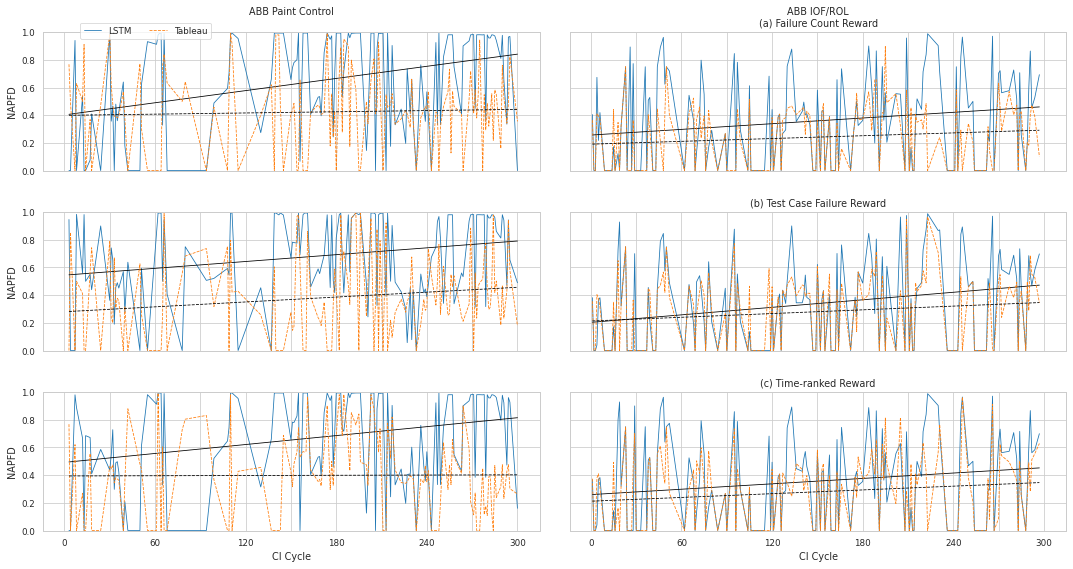

<Figure size 720x576 with 0 Axes>

In [42]:
sns.set_style('whitegrid')
sns.set_context('paper')

visualizeRQ1()

In [32]:
def visualizeRQ1_Alt():
    search_pattern = 'rq_*_stats.p'
    filename = 'rq'
    DATA_DIR = '/content'
    env_names = {
    'paintcontrol': 'ABB Paint Control',
    'iofrol': 'ABB IOF/ROL',
    'gsdtsr': 'GSDTSR'
    }
    reward_names = {
    'failcount': 'Failure Count Reward',
    'tcfail': 'Test Case Failure Reward',
    'timerank': 'Time-ranked Reward'
    }
  
    iteration_results = glob.glob(os.path.join(DATA_DIR, search_pattern))
    aggregated_results = os.path.join(DATA_DIR, filename)
    df = load_stats_dataframe(iteration_results, aggregated_results)

    pure_df = df[(~df['agent'].isin(['heur_random', 'heur_sort', 'heur_weight'])) & (df['detected'] + df['missed']) > 0]
    mean_df = pure_df.groupby(['step', 'env', 'agent', 'rewardfun'], as_index=False).mean()

    for env in mean_df['env'].unique():
        plotname = 'rq1_napfd_%s' % env
        fig, axarr = plt.subplots(1, 3, sharey=True, figsize=(15, 4))
        i = 0
  
        for rewardfun in mean_df['rewardfun'].unique():
            for agidx, (labeltext, agent, linestyle) in enumerate(
                    [('MLP', 'mlpclassifier', '-'), ('Tableau', 'tableau', '--')]):
                rel_df = mean_df[(mean_df['env'] == env) & (mean_df['rewardfun'] == rewardfun)]
                rel_df[rel_df['agent'] == agent].plot(x='step', y='napfd', label=labeltext, ylim=[0, 1], linewidth=0.8,
                                                      style=linestyle, color=sns.color_palette()[agidx], ax=axarr[i])
  
                x = rel_df.loc[rel_df['agent'] == agent, 'step']
                y = rel_df.loc[rel_df['agent'] == agent, 'napfd']
                
                #if x.size != 0 :
                trend = np.poly1d(np.polyfit(x, y, 1))
                axarr[i].plot(x, trend(x), linestyle, color='k', linewidth=0.8)
  
            axarr[i].set_xlabel('CI Cycle')
            axarr[i].legend_.remove()
            axarr[i].set_title(reward_names[rewardfun])
            axarr[i].set_xticks(np.arange(0, 350, 30), minor=False)
            axarr[i].set_xticklabels([0, '', 60, '', 120, '', 180, '', 240, '', 300], minor=False)
  
            axarr[i].xaxis.grid(True, which='minor')
  
            if i == 0:
                axarr[i].set_ylabel('NAPFD-%s'%env)
                axarr[i].legend(loc=2, frameon=True)
  
            i += 1
  
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.08)
    #save_figures(fig, plotname)
    plt.figure(figsize=((10,8)))
    plt.clf()

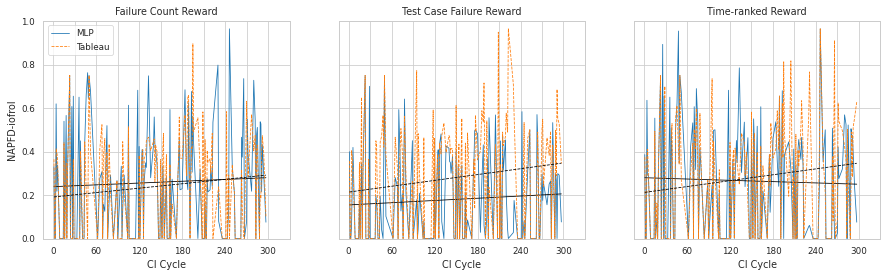

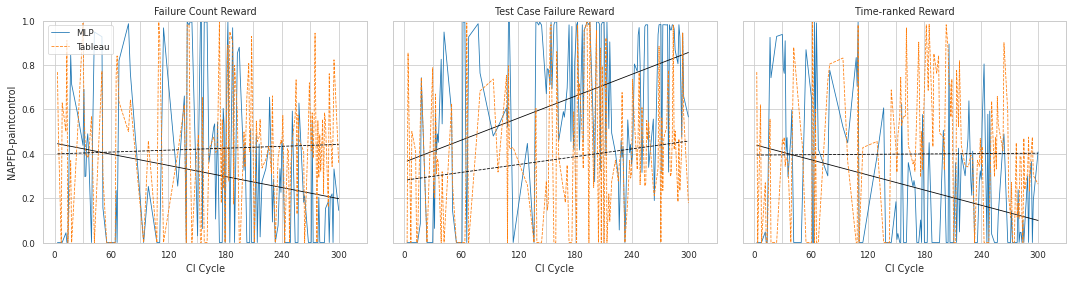

<Figure size 720x576 with 0 Axes>

In [33]:
visualizeRQ1_Alt()